# Preprocessing

## Import

In [3]:
# from pathlib import Path
import cv2
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import random
import copy
import itertools
from tqdm.notebook import tqdm

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


## Load Dataset and Preprocess with MediaPipe

In [4]:
ASL_TRAIN = '../DATA/asl/asl-alphabet-train'
ASL_TEST = '../DATA/asl/asl-alphabet-test'

In [5]:
IMG_SIZE = 224
MAX_FILES_TO_PROCESS = 3000
TRAIN_SAMPLES_PER_CLASS = 700
TEST_SAMPLES_PER_CLASS = 30

In [6]:
model_path = '../model/hand_landmarker/hand_landmarker.task'

In [7]:
options = vision.HandLandmarkerOptions(base_options=python.BaseOptions(model_asset_path=model_path),
                                       num_hands=1,
                                       running_mode=vision.RunningMode.IMAGE,
                                       min_hand_detection_confidence=0.7)
landmarker = vision.HandLandmarker.create_from_options(options)

I0000 00:00:1755505160.844326    1742 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1755505160.888581    2841 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.7-0ubuntu0.24.04.1), renderer: llvmpipe (LLVM 19.1.1, 256 bits)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1755505160.967792    2844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755505161.000005    2856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [8]:
def calc_landmark_array(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = []
    for _, landmark in enumerate(landmarks):
        landmark_x = min(int(landmark.x * image_width), image_width)
        landmark_y = min(int(landmark.y * image_height), image_height)

        landmark_array.append([landmark_x, landmark_y])

    return landmark_array

def pre_process_landmark(landmark_array):
    temp_landmark_array = copy.deepcopy(landmark_array)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark in enumerate(landmark_array):
        if index == 0:
            base_x, base_y = landmark[0], landmark[1]

        temp_landmark_array[index][0] -= base_x
        temp_landmark_array[index][1] -= base_y

    # Convert to a one-dimensional list
    temp_landmark_array = list(itertools.chain.from_iterable(temp_landmark_array))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_array)))

    def normalize_(n):
        return n / max_value

    temp_landmark_array = list(map(normalize_, temp_landmark_array))

    return temp_landmark_array

In [9]:
def extract_landmarks(img_bgr, on_score=True):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
    detection_result = landmarker.detect(mp_image)

    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness

    score = handedness_list[0][0].score
    if on_score and (score < 0.75):
        return None

    # Landmark calculation
    landmark_array = calc_landmark_array(img_rgb, hand_landmarks_list[0])

    # Convert landmarks to normalized coordinates
    pre_processed_landmark_array = pre_process_landmark(landmark_array)

    return pre_processed_landmark_array

In [10]:
def load_images(data_path, uniq_labels, sample_per_class, on_score=True):
    extract_bar = tqdm(total=len(uniq_labels) * sample_per_class, desc="Extracting landmarks", leave=True, dynamic_ncols=True)

    samples = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        label_dir = os.path.join(data_path, label)
        if not os.path.exists(label_dir):
            continue
        files = [f for f in os.listdir(label_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(files)
        files = files[:MAX_FILES_TO_PROCESS]

        sample_count = 0
        for file in files:
            if sample_count >= sample_per_class:
                break
            img_path = os.path.join(label_dir, file)

            try:
                img = cv2.imread(str(img_path))
                if img is None:
                    continue
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                landmark_array = extract_landmarks(img, on_score)

                if landmark_array is not None:
                    samples.append(landmark_array)
                    labels.append(idx)
                    sample_count += 1
                    extract_bar.update(1)

            except Exception:
                continue

    extract_bar.close()

    return samples, labels

In [11]:
uniq_labels = [label for label in sorted(os.listdir(ASL_TRAIN))
               if label.lower() not in ["nothing"]]
X_train_full, y_train_full = load_images(ASL_TRAIN, uniq_labels, TRAIN_SAMPLES_PER_CLASS)

Extracting landmarks:   0%|          | 0/19600 [00:00<?, ?it/s]

W0000 00:00:1755505161.111411    2851 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [12]:
uniq_labels = [label for label in sorted(os.listdir(ASL_TEST))
               if label.lower() not in ["nothing"]]
X_test, y_test = load_images(ASL_TEST, uniq_labels, TEST_SAMPLES_PER_CLASS, on_score=False)

Extracting landmarks:   0%|          | 0/840 [00:00<?, ?it/s]

In [13]:
(len(X_train_full), len(y_train_full)), (len(X_test), len(y_test))

((19600, 19600), (765, 765))

## Visualize

In [20]:
def label_plot(label_list):
    unique_values, counts = np.unique(label_list, return_counts=True)
    plt.figure(figsize=(10,6))
    plt.bar(uniq_labels, counts, color='skyblue')
    plt.title("Label Distribution")
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

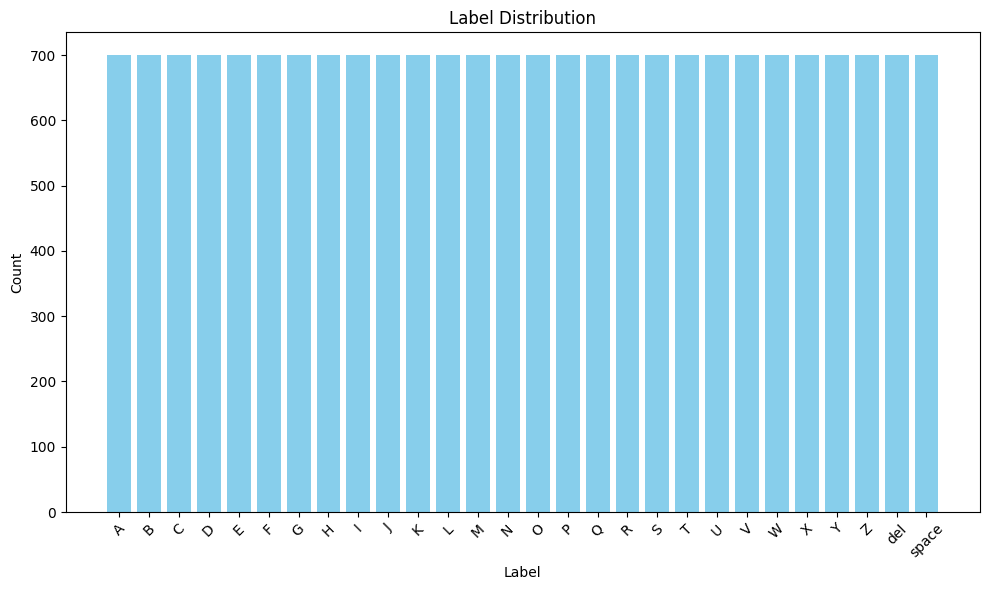

In [21]:
label_plot(y_train_full)

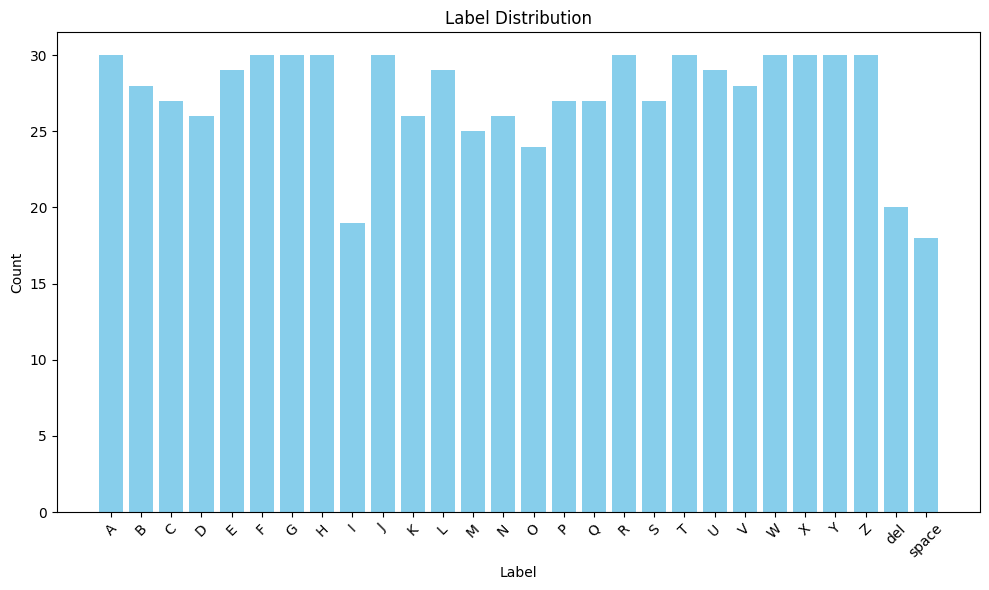

In [22]:
label_plot(y_test)

## Save processed data

In [23]:
train = np.column_stack((y_train_full, X_train_full))
test = np.column_stack((y_test, X_test))

In [26]:
# Convert the lists to pandas DataFrames
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

# Save the Train DataFrames to CSV files
train_df.to_csv('../DATA/asl/asl-landmark/train.csv', index=False, header=False)
print("train_df saved to train.csv")

# Save the Test DataFrames to CSV files
test_df.to_csv('../DATA/asl/asl-landmark/test.csv', index=False, header=False)
print("test_df saved to test.csv")

train_df saved to train.csv
test_df saved to test.csv


In [27]:
# Save uniq_labels to a CSV file
with open('../model/asl_classifier/asl_labels.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for label in uniq_labels:
        writer.writerow([label])

print("uniq_labels saved to asl_labels.csv")

uniq_labels saved to asl_labels.csv
